In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

# PLOTTING
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

# PYTORCH 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, utils

import torch.optim as optim
import torch.nn as nn

from models import Net

In [3]:
from datasetFromFile import MidiSavedDataset
midi_train_dataset = MidiSavedDataset(data_type = "train")
midi_val_dataset   = MidiSavedDataset(data_type = "val")

In [4]:
len(midi_train_dataset)

30000

In [5]:
trainloader = DataLoader(midi_train_dataset, batch_size=256,
                        shuffle=True, num_workers=6)
valloader   = DataLoader(midi_val_dataset, batch_size=256,
                        shuffle=True, num_workers=6)

In [6]:
def evaluate_metrics(preds, labels): 
    correct = 0.0
    total = 0.0
    num_true_pos_label  = 0.0
    num_false_pos_label = 0.0
    num_pos_pred  = 0.0
    num_true_neg_label  = 0.0
    num_false_neg_label = 0.0
    num_neg_pred  = 0.0

    num_timesteps = labels.shape[0]

    for i in range(num_timesteps): 
        for j in range(num_notes):
            if (labels[i,j] == 1.0):
                num_pos_pred += 1.0
            else: 
                num_neg_pred += 1.0

            if (preds[i,j] == labels[i,j]): 
                if (preds[i,j] == 1.0):
                    num_true_pos_label += 1.0
                else: 
                    num_true_neg_label += 1.0
                correct += 1.0
            else: 
                if (preds[i,j] == 1.0): 
                    num_false_pos_label += 1.0
                else: 
                    num_false_neg_label += 1.0
            total += 1.0
            
    accuracy = correct/total 
    recall = num_true_pos_label / num_pos_pred
    if (num_true_pos_label == 0 and num_false_pos_label == 0): 
        precision = 1
    else: 
        precision = num_true_pos_label/ (num_true_pos_label + num_false_pos_label)
    
    print("Correct: ", correct, ", Num pos: ", num_pos_pred, "num true pos: ", num_true_pos_label, "num false pos: ", num_false_pos_label, ", accuracy: ", accuracy, ", recall: ", recall)
    
    return accuracy, recall, precision

In [7]:
sigmoid = torch.nn.Sigmoid()

### Vary pos weight

In [8]:
pos_weight_train_loss_list = []
pos_weight_val_loss_list = []

pos_weight_val_preds_list  = []
pos_weight_val_labels_list = []

list_pos_weight = [0.1, 1.0, 200.0]
# list_pos_weight = [1.0]

val_preds_list  = []
val_labels_list = []
train_loss_list = []
val_loss_list   = []


num_notes = 128

for pos_weight in list_pos_weight: 
    val_preds_list  = []
    val_labels_list = []
    train_loss_list = []
    val_loss_list   = []

    net = Net().cuda().double()
    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([pos_weight])).cuda()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

    for epoch in range(4):  # loop over the dataset multiple times

        # TRAIN 
        train_labels = np.zeros((len(trainloader.dataset), num_notes))
        train_preds  = np.zeros((len(trainloader.dataset), num_notes))
        idx = 0
        for i, data in enumerate(trainloader, 0):
            #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.double())
            loss = criterion(outputs, labels.double())
            loss.backward()
            optimizer.step()

            train_labels[idx:idx+labels.shape[0], :] = labels.cpu().detach().numpy()
            train_preds[idx:idx+labels.shape[0], :]  = sigmoid(outputs.cpu().detach()).numpy()

#             print("Iter: ", i, ", Loss: ", loss.item())

            # Get loss 
            train_loss_list.append(loss.item())

       # VALIDATE
            sum_val_loss = 0
            val_labels = np.zeros((len(valloader.dataset), num_notes))
            val_preds  = np.zeros((len(valloader.dataset), num_notes))
            with torch.no_grad():
                for i, data in enumerate(valloader,0):
                    inputs, labels = data
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    outputs = net(inputs.double())

                    loss = criterion(outputs, labels.double())

                    sum_val_loss += loss.item()

                    val_labels[idx:idx+labels.shape[0], :] = labels.cpu().detach().numpy()
                    val_preds[idx:idx+labels.shape[0], :]  = sigmoid(outputs.cpu().detach()).numpy()

                    val_labels_list.append(val_labels)
                    val_preds_list.append(val_preds)
            # Loss 
            avg_val_loss = sum_val_loss / len(valloader)
            val_loss_list.append(avg_val_loss)
        print("Epoch: ", epoch)

    pos_weight_val_preds_list.append(val_preds_list)
    pos_weight_val_labels_list.append(val_labels_list)
    
    pos_weight_train_loss_list.append(train_loss_list)
    pos_weight_val_loss_list.append(val_loss_list)

    
    print('Finished Training with pos weight: ', pos_weight)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Finished Training with pos weight:  0.1
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Finished Training with pos weight:  1.0
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Finished Training with pos weight:  200.0


In [9]:
PATH = './midi_net.pth'
torch.save(net.state_dict(), PATH)

In [15]:
n_pos_weight = len(pos_weight_train_loss_list)

for j in range(1): 
    pos_weight_val_preds_list[j]  = np.vstack(pos_weight_val_preds_list[j])
    pos_weight_val_labels_list[j] = np.vstack(pos_weight_val_labels_list[j])
    
n_classes = pos_weight_val_preds_list[0].shape[1]

pos_weight_labels = ['0.1', '1.0', '200.0']

MemoryError: Unable to allocate array with shape (26550000, 128) and data type float64

In [18]:
print(pos_weight_val_preds_list[1][0].shape)

(3750, 128)


### Loss

#### One weight 

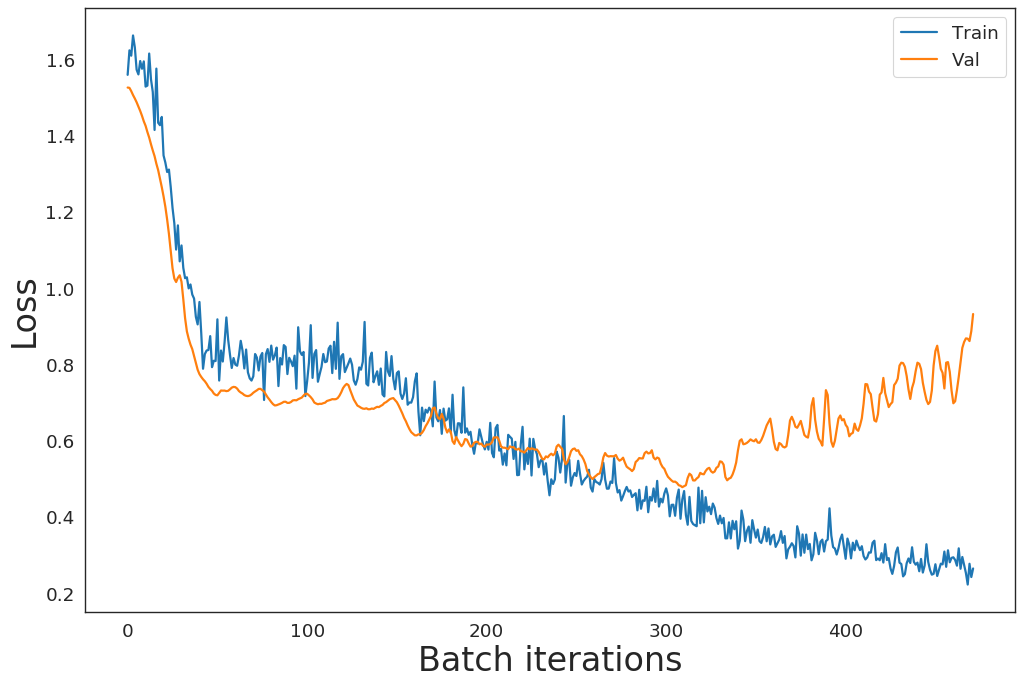

In [11]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Batch iterations', fontsize=30)
plt.ylabel('Loss', fontsize=30)

plt.plot(train_loss_list, label='Train', linewidth=2)
plt.plot(val_loss_list,   label='Val', linewidth=2)

plt.legend()
plt.show()

#### List over pos weights

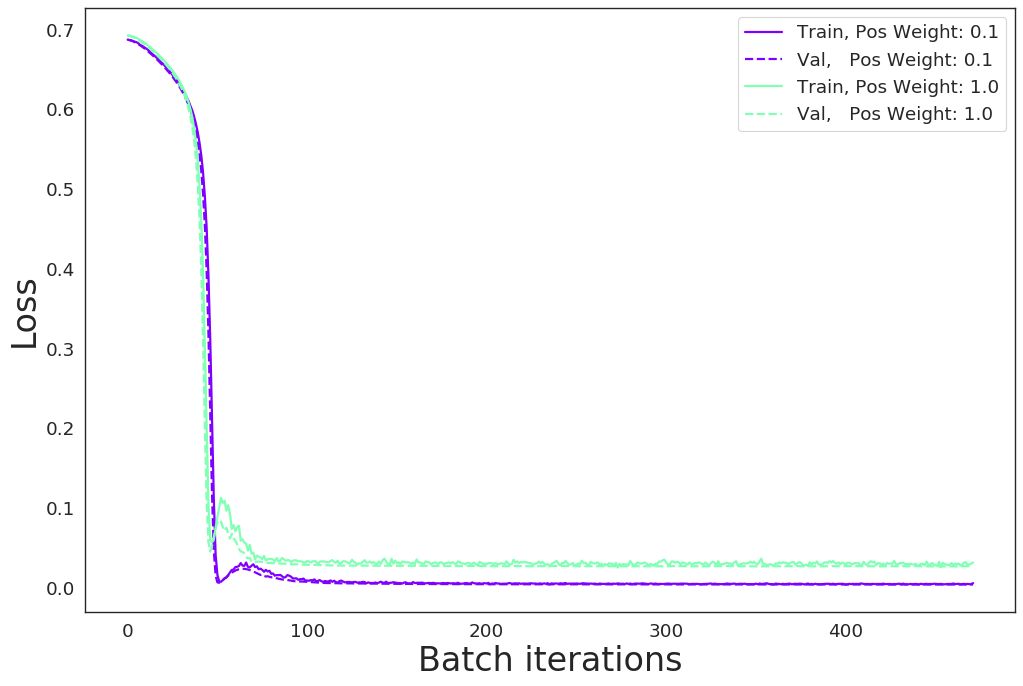

In [14]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Batch iterations', fontsize=30)
plt.ylabel('Loss', fontsize=30)

n_pos_weight = len(pos_weight_train_loss_list)
color=iter(cm.rainbow(np.linspace(0,1,n_pos_weight)))
for j in range(2):
    c=next(color)
    pos_weight = list_pos_weight[j]
    plt.plot(pos_weight_train_loss_list[j], c=c, label='Train, Pos Weight: ' + str(pos_weight), linewidth=2)
    plt.plot(pos_weight_val_loss_list[j],   c=c, linestyle='--',label='Val,   Pos Weight: ' + str(pos_weight), linewidth=2)

plt.legend()
plt.show()

### Precision Recall Curve

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average precision score, micro-averaged over all classes: 0.01


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average precision score, micro-averaged over all classes: 0.01


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Average precision score, micro-averaged over all classes: 0.03


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


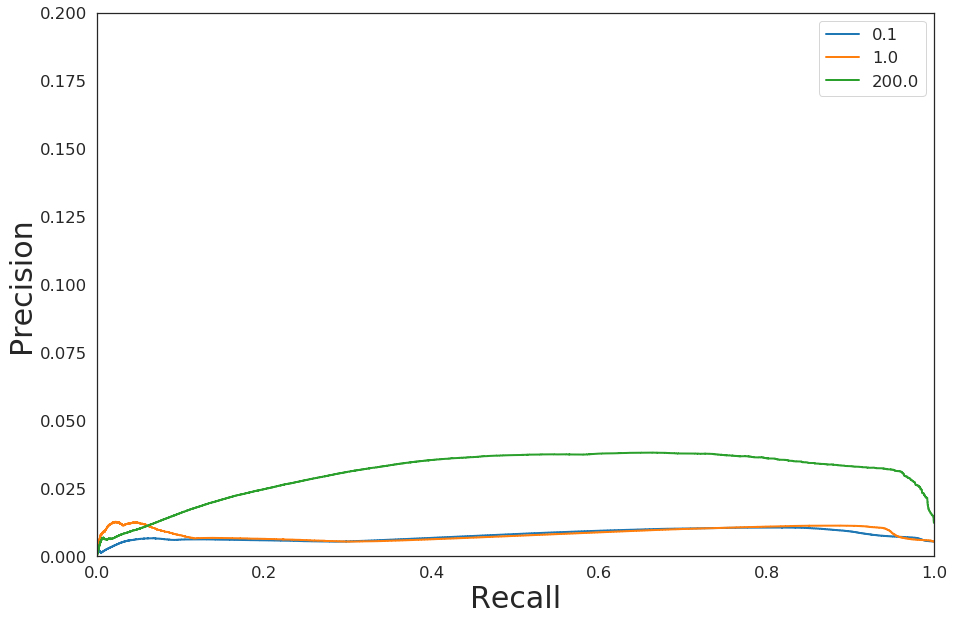

In [62]:
# val_preds_array = np.vstack(val_preds_list)
# val_labels_array = np.vstack(val_labels_list)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import math

plt.figure(figsize=(15,10))
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.ylim([0.0, 0.2])
plt.xlim([0.0, 1.0])

for j in range(n_pos_weight): 
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(pos_weight_val_labels_list[j][:, i],
                                                            pos_weight_val_preds_list[j][:, i])
        average_precision[i] = average_precision_score(pos_weight_val_labels_list[j][:, i], pos_weight_val_preds_list[j][:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(pos_weight_val_labels_list[j].ravel(),
        pos_weight_val_preds_list[j].ravel())
    average_precision["micro"] = average_precision_score(pos_weight_val_labels_list[j], pos_weight_val_preds_list[j] ,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))


    plt.step(recall['micro'], precision['micro'], where='post', label = pos_weight_labels[j], linewidth = 2)

# plt.title(
#     'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
#     .format(average_precision["micro"]))
plt.legend()

### ROC Curve

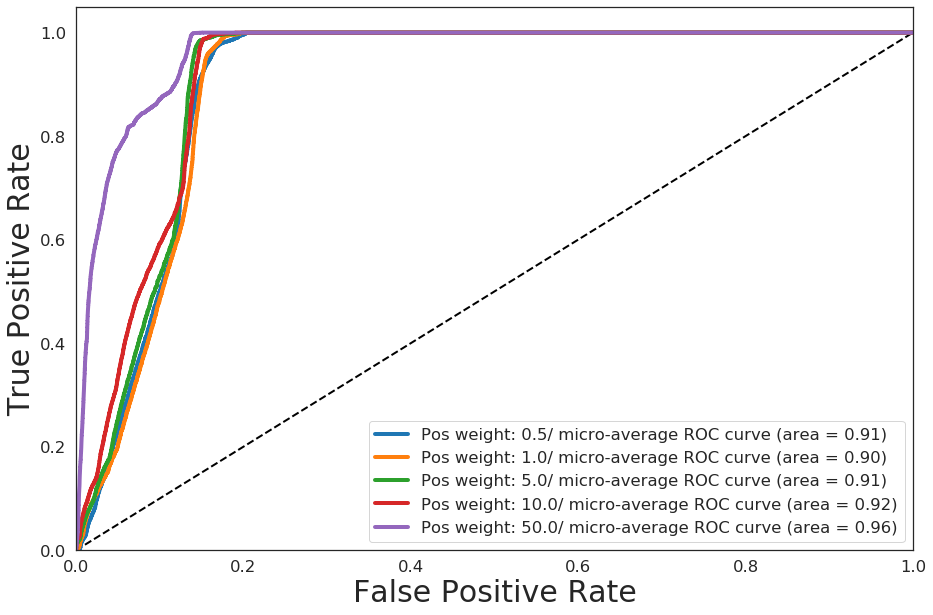

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=30)
plt.ylabel('True Positive Rate', fontsize=30)
    
for j in range(n_pos_weight):
    val_preds_array  = np.vstack(pos_weight_val_preds_list[j])
    val_labels_array = np.vstack(pos_weight_val_labels_list[j])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(val_labels_array[:, i], val_preds_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(val_labels_array.ravel(), val_preds_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.plot(fpr["micro"], tpr["micro"],
         label='Pos weight: ' + pos_weight_labels[j] + '/ micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), linewidth=4)
    
plt.legend(loc="lower right")
plt.show()